In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.cluster import KMeans

In [2]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount = True)

Mounted at /content/gdrive


In [3]:
root = "/content/gdrive/MyDrive/COMP448/"
dataset = os.path.join(root, "Dataset")
os.chdir(root)

In [4]:
### we must call these functions when cwd is the directory where we put them
def read_image(imName):
    im = cv.imread(imName)
    return np.flip(im, 2)

def write_image(im, imName):
    im = cv.imwrite(imName, cv.cvtColor(im, cv.COLOR_RGB2BGR))

In [5]:
def plot_image(im, w, h, cmap = "gray", title = False):
    fig = plt.figure(figsize = (w, h))
    plt.imshow(im, cmap = cmap, interpolation = "none")
    plt.xticks([])
    plt.yticks([])
    if title:
        plt.title(title)

In [6]:
def plot_segmentation(im, mask, w, h):
    imc = np.copy(im)
    fig = plt.figure(figsize = (w, h))
    imc[:,:,0][mask] = 0
    imc[:,:,1][mask] = 0
    imc[:,:,2][mask] = 0
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imc, interpolation = "none")


In [7]:
def clustering(image):
    height, width, channels = image.shape

    kmeans = KMeans(n_clusters = 2, n_init = 3).fit(image.reshape(height*width, channels))
    clusters = kmeans.labels_
    means = kmeans.cluster_centers_

    # Create an empty image array
    clustered_image = np.zeros((height, width), dtype=np.uint8)

    # Reshape the clusters array to the shape of the original image
    clusters = clusters.reshape(height, width)

    # Determine which cluster is darker
    if np.linalg.norm(means[0]) < np.linalg.norm(means[1]):
        dark_cluster = 0
        light_cluster = 1
    else:
        dark_cluster = 1
        light_cluster = 0

    # We want to choose the dark_clusters as our mask
    clustered_image[clusters == dark_cluster] = 1
    clustered_image[clusters == light_cluster] = 0

    return clustered_image

In [8]:
def adjust_crop_window(height, width, hnew, wnew, center):
  rmin = center[0] - int(hnew / 2) - 1
  rmax = center[0] + int(hnew / 2) + 1

  cmin = center[1] - int(wnew / 2) - 1
  cmax = center[1] + int(wnew / 2) + 1


  if rmin < 0:
    rmax = rmax - rmin
    rmin = 0

  if rmax > height:
    rmin = rmin - (rmax - height)
    rmax = height

  if cmin < 0:
    cmax = cmax - cmin
    cmin = 0

  if cmax > width:
    cmin = cmin - (cmax - width)
    cmax = width

  return rmin, rmax, cmin, cmax

def crop_and_resize(img, clustered, alpha = 0.25, ignore_margin = 50, minheight = 150, minwidth = 200, plots = False):
  h = img.shape[0]
  w = img.shape[1]
  imarea = h*w

  ignore_pad = np.ones((h, w))
  ignore_pad[:ignore_margin, :] = 0
  ignore_pad[(h - ignore_margin):, :] = 0
  ignore_pad[:, :ignore_margin] = 0
  ignore_pad[:, (w - ignore_margin):] = 0

  central = clustered*ignore_pad
  region = np.count_nonzero(central)
  if region/imarea < alpha:
    x = np.sqrt(region / (imarea*alpha))

    wnew = max(int(x*w), minwidth)
    hnew = max(int(x*h), minheight)

    locs = np.transpose(np.nonzero(central))
    center = np.mean(locs, axis = 0).round().astype("int32")

    rmin, rmax, cmin, cmax = adjust_crop_window(h, w, hnew, wnew, center)

    resized = cv.resize(img[rmin:rmax, cmin:cmax], (600, 450), interpolation = cv.INTER_CUBIC)

    if plots:
      box = np.zeros((450, 600)).astype("bool")

      box[rmin, cmin:cmax] = True
      box[rmax, cmin:cmax] = True
      box[rmin:rmax, cmin] = True
      box[rmin:rmax, cmax] = True

      plot_segmentation(img, box, 7, 7, title = "segmentation")
      plot_image(resized, 7, 7, title = "resized image")

    return resized

  return img




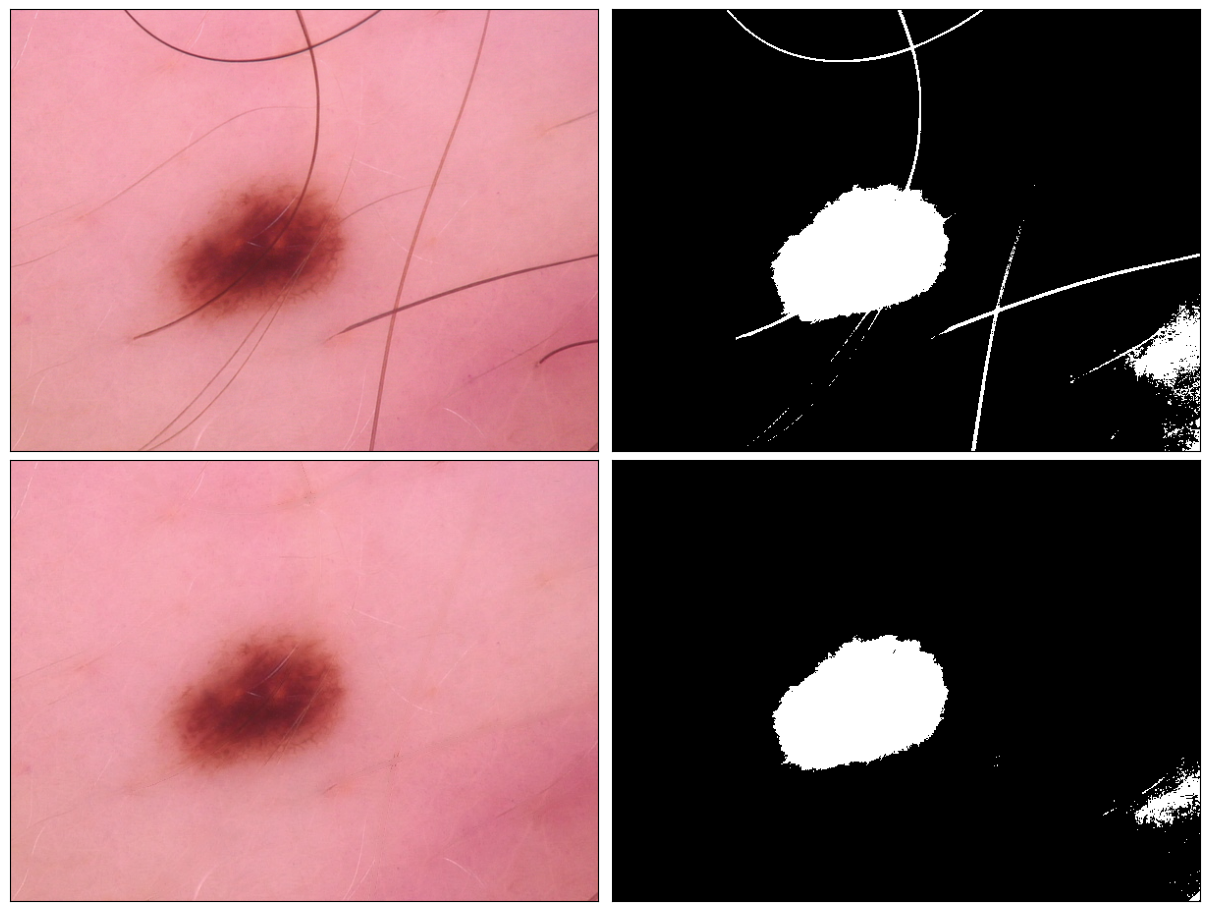

In [16]:
os.chdir(os.path.join(dataset, "unprocessed_dataset"))
i = np.random.randint(0, len(os.listdir()))
name = os.listdir()[i]
img = read_image(name)

clustered = clustering(img)

os.chdir(os.path.join(dataset, "processed_dataset_3"))
pimg = read_image(name)
pclustered = clustering(pimg)

fig, axes = plt.subplots(2, 2, subplot_kw = {"xticks" : [], "yticks" : []}, figsize = (12, 9), layout = "constrained")

axes[0,0].imshow(img)
axes[0,1].imshow(clustered, cmap = "gray")

axes[1,0].imshow(pimg)
axes[1,1].imshow(pclustered, cmap = "gray")
plt.show()

In [14]:
image = read_image(os.path.join(dataset, "processed_dataset_3", "ISIC_0029287.jpg"))
clustered = clustering(image)
reduced = crop_and_resize(image, clustered)

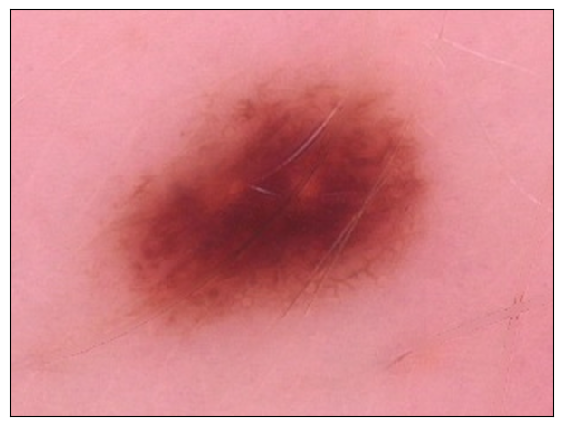

In [15]:
plot_image(reduced, 7, 7)

In [ ]:
def process_images(input_path, output_path):
  os.mkdir(output_path)
  ims = os.listdir(input_path)
  n = len(ims)
  checkpoint = 0
  for i in range(n):
    if (10*i)//n > checkpoint:
      print(f"%{10*(checkpoint + 1)} of images are processed.")
      checkpoint += 1
    image = read_image(os.path.join(input_path, ims[i]))
    clustered = clustering(image)
    processed = crop_and_resize(image, clustered)
    write_image(processed, os.path.join(output_path, ims[i]))

In [ ]:
classes = os.listdir(os.path.join(dataset, "Test_p1"))
os.mkdir(os.path.join(dataset, "Test_p2"))
for c in classes:
  print(f"Processing Test_p1/{c} images")
  process_images(os.path.join(dataset, "Test_p1", c), os.path.join(dataset, "Test_p2", c))

Processing Test_p1/AKIEC images
%10 of images are processed.
%20 of images are processed.
%30 of images are processed.
%40 of images are processed.
%50 of images are processed.
%60 of images are processed.
%70 of images are processed.
%80 of images are processed.
%90 of images are processed.
Processing Test_p1/BCC images
%10 of images are processed.
%20 of images are processed.
%30 of images are processed.
%40 of images are processed.
%50 of images are processed.
%60 of images are processed.
%70 of images are processed.
%80 of images are processed.
%90 of images are processed.
Processing Test_p1/BKL images
%10 of images are processed.
%20 of images are processed.
%30 of images are processed.
%40 of images are processed.
%50 of images are processed.
%60 of images are processed.
%70 of images are processed.
%80 of images are processed.
%90 of images are processed.
Processing Test_p1/DF images
%10 of images are processed.
%20 of images are processed.
%30 of images are processed.
%40 of im